In [ ]:
!pip install mplfinance
!pip install pandas
!pip install matplotlib

In [2]:
file_path = "5min_47100CE.csv"

In [3]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_path)

# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Daily High, Low, and Close
daily_high = df['high'].max()
daily_low = df['low'].min()
daily_close = df['close'].iloc[-1]  # Last close of the day

# Pivot Point
pivot = (daily_high + daily_low + daily_close) / 3

# Fibonacci Levels
range_ = daily_high - daily_low
r1 = pivot + 0.382 * range_
r2 = pivot + 0.618 * range_
r3 = pivot + range_
s1 = pivot - 0.382 * range_
s2 = pivot - 0.618 * range_
s3 = pivot - range_

# Display Results
print("Fibonacci Pivot Points for 10th Jan 2024:")
print(f"Pivot Point (P): {pivot:.2f}")
print(f"R1: {r1:.2f}")
print(f"R2: {r2:.2f}")
print(f"R3: {r3:.2f}")
print(f"S1: {s1:.2f}")
print(f"S2: {s2:.2f}")
print(f"S3: {s3:.2f}")

# Plotting the chart
# Create a custom style for the plot
fib_lines = [
    mpf.make_addplot([pivot] * len(df), color='blue', linestyle='--', panel=0, secondary_y=False),
    mpf.make_addplot([r1] * len(df), color='green', linestyle='--', panel=0, secondary_y=False),
    mpf.make_addplot([r2] * len(df), color='red', linestyle='--', panel=0, secondary_y=False),
    mpf.make_addplot([r3] * len(df), color='orange', linestyle='--', panel=0, secondary_y=False),
    mpf.make_addplot([s1] * len(df), color='green', linestyle='--', panel=0, secondary_y=False),
    mpf.make_addplot([s2] * len(df), color='red', linestyle='--', panel=0, secondary_y=False),
    mpf.make_addplot([s3] * len(df), color='orange', linestyle='--', panel=0, secondary_y=False),
]

# Plot the candlestick chart with Fibonacci levels
mpf.plot(df, type='candle', style='charles', title="Fibonacci Pivot Points", ylabel="Price", addplot=fib_lines)

# Optionally, save the plot to a file (e.g., 'fibonacci_pivots.png')
# plt.savefig("fibonacci_pivots.png", dpi=300, bbox_inches="tight")

plt.show()  # Show the plot


FileNotFoundError: [Errno 2] No such file or directory: '5min_47100CE.csv'

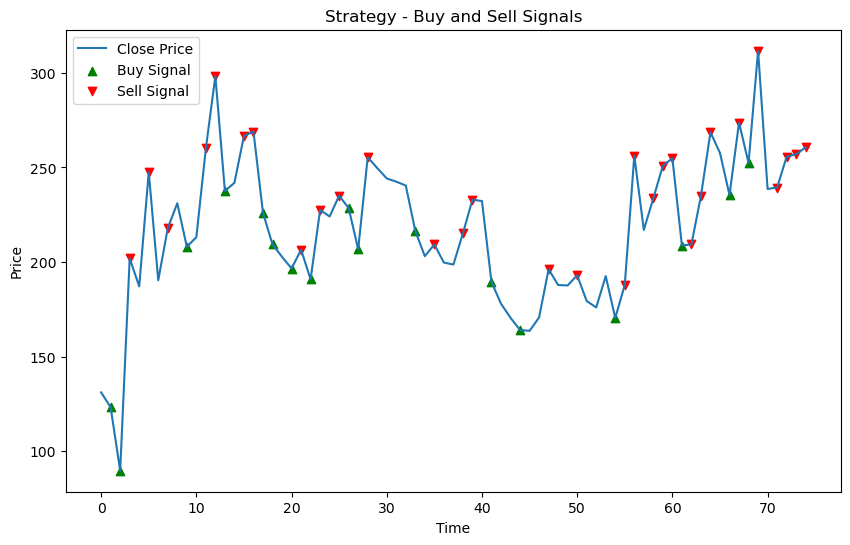

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame with 'date', 'open', 'high', 'low', 'close', 'volume'
def identify_marubozu(df, tolerance=0.1):
    # Bullish Marubozu: Open near low, Close near high
    df['bullish_marubozu'] = (df['close'] >= (1 - tolerance) * df['high']) & (df['close'] <= (1 + tolerance) * df['high']) & \
                             (df['open'] <= (1 + tolerance) * df['low']) & (df['open'] >= (1 - tolerance) * df['low'])
    
    # Bearish Marubozu: Open near high, Close near low
    df['bearish_marubozu'] = (df['open'] >= (1 - tolerance) * df['high']) & (df['open'] <= (1 + tolerance) * df['high']) & \
                             (df['close'] <= (1 + tolerance) * df['low']) & (df['close'] >= (1 - tolerance) * df['low'])
    
    return df


# Function to generate Buy/Sell signals based on Marubozu pattern
def generate_signals(df):
    signals = []
    
    for i in range(1, len(df)):
        if df['bullish_marubozu'][i]:
            if df['close'][i] > df['close'][i-1]:  # Confirmation (Price moves higher after Bullish Marubozu)
                signals.append('Sell')
            else:
                signals.append('')
        
        elif df['bearish_marubozu'][i]:
            if df['close'][i] < df['close'][i-1]:  # Confirmation (Price moves lower after Bearish Marubozu)
                signals.append('Buy')
            else:
                signals.append('')
        else:
            signals.append('')
    
    df['signals'] = [''] + signals  # First row won't have a signal
    return df

# Example of how to use the strategy on a 5-minute dataframe
df = pd.read_csv(file_path)  # Replace with your actual 5-minute OHLC data
df = identify_marubozu(df)
df = generate_signals(df)

# Plot the signals on the chart
plt.figure(figsize=(10, 6))
plt.plot(df['close'], label="Close Price")

# Plot Buy and Sell signals
buy_signals = df[df['signals'] == 'Buy']
sell_signals = df[df['signals'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1)

plt.title('Strategy - Buy and Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


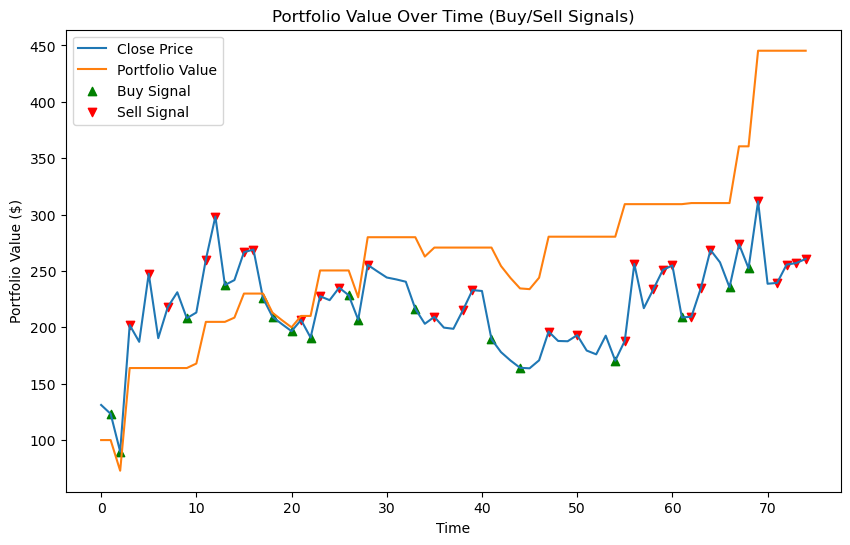

In [12]:
def calculate_portfolio(df, initial_balance=100):
    balance = initial_balance
    shares_held = 0  # Tracks the number of shares held
    portfolio_values = []  # Stores portfolio value over time for visualization

    for i in range(1, len(df)):
        signal = df['signals'][i]
        
        if signal == 'Buy':
            # Buy partial shares, assuming buy signal at the current close price
            if balance > 0:
                # Buy as much as possible with current balance
                shares_bought = balance / df['close'][i]
                shares_held += shares_bought
                balance = 0  # All balance is used up for buying
            else:
                # If there's no cash, skip the buy signal
                pass

        elif signal == 'Sell':
            # Sell all shares, assuming sell signal at the current close price
            if shares_held > 0:
                balance += shares_held * df['close'][i]  # Selling all shares at the current price
                shares_held = 0  # All shares are sold

        # Track portfolio value (balance + value of shares held)
        portfolio_value = balance + (shares_held * df['close'][i])
        portfolio_values.append(portfolio_value)

    # Append the final portfolio value to the DataFrame
    df['portfolio_value'] = [initial_balance] + portfolio_values  # Include initial balance
    return df

# Example of using this function on a 5-minute data set with Marubozu signals
df = pd.read_csv(file_path)  # Replace with your actual 5-minute OHLC data
df = identify_marubozu(df)
df = generate_signals(df)
df = calculate_portfolio(df)

# Plot the portfolio value over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['close'], label="Close Price")
plt.plot(df['portfolio_value'], label="Portfolio Value")
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title('Portfolio Value Over Time (Buy/Sell Signals)')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
